<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/pivot-point-driven-pendulum-Vinnie369/blob/main/Pivot_PivotDriven_Pendulum_Workbook_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pivot-Point-Driven Pendulum — Colab Workbook (Updated y_p)

## Overview

We simulate and analyze a rigid pendulum whose **pivot point moves in a circle** of radius \(l\) about the pendulum’s initial equilibrium position. The **updated** pivot motion is
\[
x_p(t) = -\,l\sin(\omega_d t),\qquad
y_p(t) = l\bigl(\cos(\omega_d t) - 1\bigr).
\]

The bob starts at rest hanging vertically: \(\theta(0)=0\), \(\dot\theta(0)=0\).  
We will:
1. Build a reproducible workflow (this notebook) that simulates the dynamics.
2. Visualize the motion with an animation helper.
3. Perform a small-angle analytic stability analysis for \(\theta\approx 0\) **consistent with the updated \(y_p(t)\)**.


In [1]:

# --- Imports & global settings ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12



## Geometry helpers


In [2]:

def get_pivot_xy(t, omega_d, x_p0=0.0, y_p0=0.0, l=1.0):
    """Circular pivot trajectory of radius l around (x_p0, y_p0).
    Updated: y_p(t) = y_p0 + l (cos(ω_d t) - 1)
    """
    t = np.asarray(t)
    x = x_p0 - l*np.sin(omega_d*t)
    y = y_p0 + l*(np.cos(omega_d*t) - 1.0)
    return x, y

def get_pendulum_xy(t, theta, l=1.0):
    """Bob coordinates *relative to the pivot* for angle theta (downward=0)."""
    x_rel = l*np.sin(theta)
    y_rel = -l*np.cos(theta)
    return x_rel, y_rel

def get_lab_xy(x_pivot, y_pivot, x_rel, y_rel):
    """Bob coordinates in the lab frame."""
    return x_pivot + x_rel, y_pivot + y_rel



## Animation helper

In [3]:

# create pendulum animation (provided function)
def create_pendulum_animation(t, x_pivot, y_pivot, x_lab, y_lab, l=1, show_traj=False, speed_factor=1.0):
    """
    Creates an animation of the pivot-driven pendulum.
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(np.min(x_pivot) - l, np.max(x_pivot) + l)
    ax.set_ylim(np.min(y_pivot) - l, np.max(y_pivot) + l)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    pivot, = ax.plot([], [], 'o', color='black', markersize=8, label='Pivot')
    pendulum_arm, = ax.plot([], [], '-', color='black', lw=2, label='Pendulum Arm')
    pendulum_bob, = ax.plot([], [], 'o', color='red', markersize=12, label='Pendulum Bob')
    trajectory = None

    if show_traj:
        trajectory, = ax.plot([], [], '-', color='gray', lw=1, alpha=0.5, label='Trajectory')

    def animate(i):
        pivot.set_data([x_pivot[i]], [y_pivot[i]])
        pendulum_arm.set_data([x_pivot[i], x_lab[i]], [y_pivot[i], y_lab[i]])
        pendulum_bob.set_data([x_lab[i]], [y_lab[i]])
        artists = [pivot, pendulum_arm, pendulum_bob]
        if show_traj and trajectory:
            trajectory.set_data(x_lab[:i+1], y_lab[:i+1])
            artists.append(trajectory)
        return artists

    average_time_step = np.mean(np.diff(t))
    interval = average_time_step * 1000 * speed_factor
    anim = FuncAnimation(fig, animate, frames=len(t), interval=interval, blit=True)
    plt.close(fig)
    return anim



## Equations of motion (updated with new \(y_p\))

From Lagrange’s method:
\[
\ddot\theta + \frac{g}{l}\sin\theta + \frac{\ddot x_p\cos\theta + \ddot y_p\sin\theta}{l} = 0.
\]
Updated drive:
\[
\ddot x_p = l\omega_d^2 \sin(\omega_d t),\qquad \ddot y_p = -\,l\omega_d^2 \cos(\omega_d t).
\]
Linearized about \(\theta=0\):
\[
\boxed{\ \ddot\theta + \Bigl(\tfrac{g}{l}-\omega_d^2\cos\omega_d t\Bigr)\theta + \omega_d^2\sin(\omega_d t)=0\ }.
\]


In [4]:

def theta_ode(t, y, params):
    theta, theta_dot = y
    g = params['g']
    l = params['l']
    omega_d = params['omega_d']

    x_pp =  l*(omega_d**2)*np.sin(omega_d*t)
    y_pp = -l*(omega_d**2)*np.cos(omega_d*t)

    theta_ddot = -(g/l)*np.sin(theta) - (x_pp*np.cos(theta) + y_pp*np.sin(theta))/l
    return np.array([theta_dot, theta_ddot])



## Parameters & initial conditions


In [5]:

g = 9.81
l = 1.0
omega0 = np.sqrt(g/l)

regimes = {
    "low (0.3 ω0)": 0.3*omega0,
    "resonant (1.0 ω0)": 1.0*omega0,
    "parametric (2.0 ω0)": 2.0*omega0,
    "high (6.0 ω0)": 6.0*omega0
}

theta0 = 0.0
thetadot0 = 0.0

t_min = 0.0
t_max = 30.0
t_eval = np.linspace(t_min, t_max, 6001)



## Run simulations


In [6]:

solns = {}
for label, omega_d in regimes.items():
    params = dict(g=g, l=l, omega_d=omega_d)
    sol = solve_ivp(lambda t, y: theta_ode(t, y, params),
                    (t_min, t_max),
                    y0=[theta0, thetadot0],
                    t_eval=t_eval,
                    rtol=1e-8, atol=1e-10, dense_output=True)
    solns[label] = (sol, params)
len(solns)


4


## Plot θ(t)


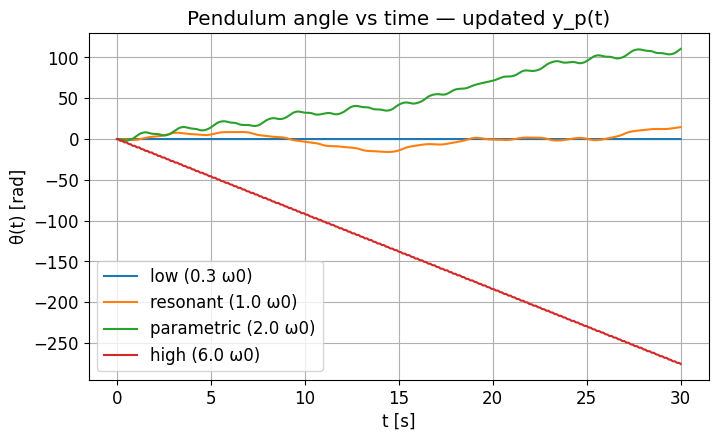

In [7]:

fig, ax = plt.subplots(figsize=(8,4.5))
for label, (sol, params) in solns.items():
    ax.plot(sol.t, sol.y[0], label=label)
ax.set_xlabel('t [s]')
ax.set_ylabel('θ(t) [rad]')
ax.set_title('Pendulum angle vs time — updated y_p(t)')
ax.legend()
plt.show()



## Phase portrait (resonant)


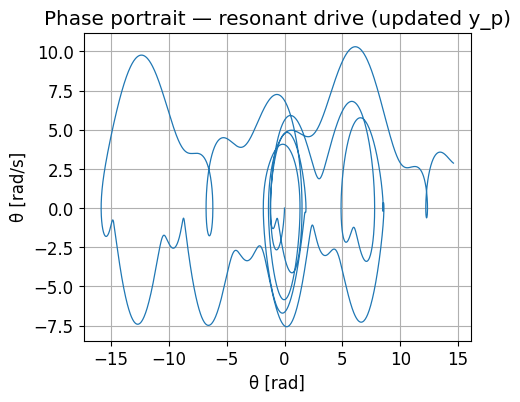

In [8]:

label = "resonant (1.0 ω0)"
sol, params = solns[label]
plt.figure(figsize=(5,4))
plt.plot(sol.y[0], sol.y[1], lw=0.9)
plt.xlabel('θ [rad]')
plt.ylabel('θ̇ [rad/s]')
plt.title('Phase portrait — resonant drive (updated y_p)')
plt.grid(True)
plt.show()



## Lab-frame trajectory & animation (high frequency)


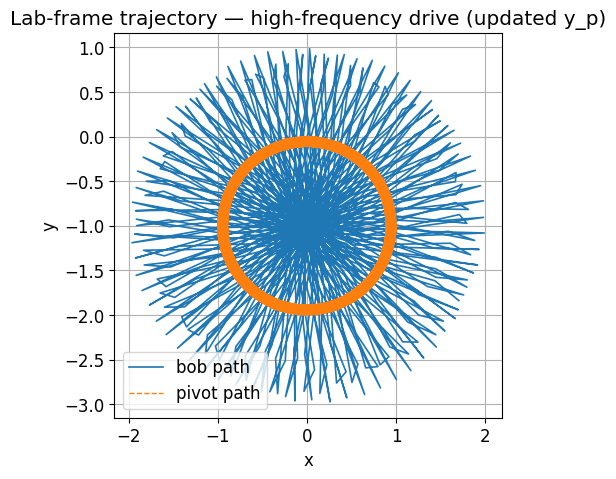

In [9]:

label = "high (6.0 ω0)"
sol, params = solns[label]

n_points = 600
t_plot = np.linspace(t_min, t_max, n_points)
theta_plot = sol.sol(t_plot)[0]

x_pivot, y_pivot = get_pivot_xy(t_plot, params['omega_d'], l=l)
x_rel, y_rel = get_pendulum_xy(t_plot, theta_plot, l=l)
x_lab, y_lab = get_lab_xy(x_pivot, y_pivot, x_rel, y_rel)

plt.figure(figsize=(5,5))
plt.plot(x_lab, y_lab, lw=1.2, label='bob path')
plt.plot(x_pivot, y_pivot, '--', lw=1.0, label='pivot path')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lab-frame trajectory — high-frequency drive (updated y_p)')
plt.legend()
plt.show()

anim = create_pendulum_animation(t_plot, x_pivot, y_pivot, x_lab, y_lab, l=l, show_traj=True, speed_factor=4.0)
HTML(anim.to_html5_video())



## Stability conclusions (what the assignment asks)

- **Start from rest** \((\theta_0=\dot\theta_0=0)\):  
  - **Low \(\omega_d\ll\omega_0\)** → small, near-static motion (bob nearly stationary).  
  - **Near \(\omega_d\approx\omega_0\)** → large response from **additive forcing**; equilibrium **not** robust.  
  - **Near \(\omega_d\approx2\omega_0\)** → **parametric instability** possible even from zero amplitude.  
  - **High \(\omega_d\gg\omega_0\)** → fast modulation averages out; **stable small oscillations** about \(\theta\approx0\).



